# Fidelity test ressults test

In [6]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Compute Fidelity
def ABSCosineSimilarityFrobenius(target_matrix, predicted_matrix):
    target_matrix_H = target_matrix.conj().T
    predicted_matrix_H = predicted_matrix.conj().T
    trace_tH_t = np.trace(np.dot(target_matrix_H, target_matrix)).real          # result is REAL
    trace_pH_p = np.trace(np.dot(predicted_matrix_H, predicted_matrix)).real    # result is REAL
    trace_pH_t = np.trace(np.dot(predicted_matrix_H, target_matrix))
    cosine_similarity = trace_pH_t/np.sqrt(trace_tH_t*trace_pH_p)
    cosine_similarity = np.abs(cosine_similarity)   # Take the abs 
    return cosine_similarity

In [8]:
# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

In [9]:
# Derive the FIDELITY for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_Fidelity_1sim(target_tuples, predit_tuples):
    fidelity = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            fidelity.extend([ABSCosineSimilarityFrobenius(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    fidelity_pd = pd.DataFrame({'label': labels, 'value': fidelity})
    return fidelity_pd

In [10]:
# Take best result MAXIMUM value repetition
def models_repmax_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find min
    max_lastFidelity_s = df.groupby('label_no_rep')['value'].max()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = max_lastFidelity_s[max_lastFidelity_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models

# SAVE everything
[(simulation hyp, name model, average, deviation std)]

In [11]:
directory_run = 'outdata/20240603_test_result_fidelity'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        mse_pd = derive_Fidelity_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmax_mean_devstd(mse_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/run_ave_dev_save.npy', ave_devstd_run_nparray)

# Grapth

In [12]:
# Extrat the iloss and imb from the simulation label
def extract_values(label):
    match = re.search(r'iloss([-+]?[0-9]*\.?[0-9]+)_imb([-+]?[0-9]*\.?[0-9]+)', label)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

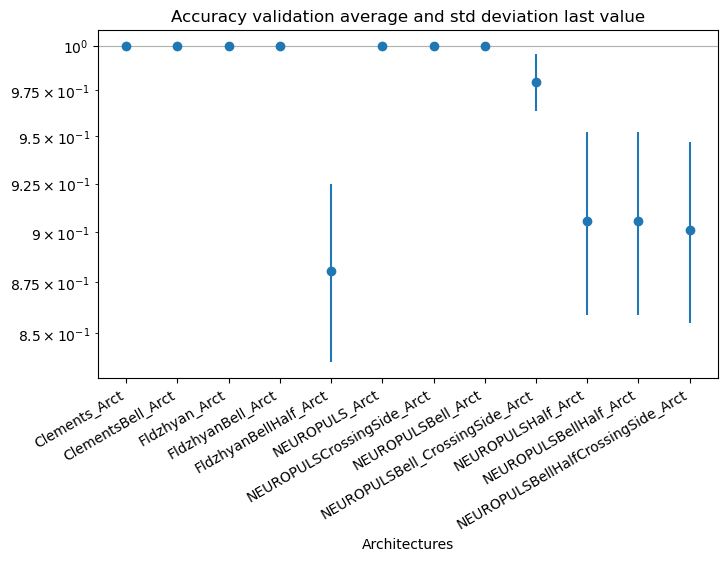

,label,average_value,std_dev_value
0,Clements_Arct,1.000000,2.395987e-08
1,ClementsBell_Arct,1.000000,3.518565e-08
2,Fldzhyan_Arct,0.999870,1.916104e-04
3,FldzhyanBell_Arct,0.999981,5.881488e-05
4,FldzhyanBellHalf_Arct,0.880547,4.408610e-02
5,NEUROPULS_Arct,1.000000,1.201621e-08
6,NEUROPULSCrossingSide_Arct,1.000000,1.512882e-08
7,NEUROPULSBell_Arct,1.000000,1.525545e-08
8,NEUROPULSBell_CrossingSide_Arct,0.979704,1.583770e-02
9,NEUROPULSHalf_Arct,0.905644,4.653971e-02


In [19]:
directory_run = 'outdata/20240603_test_result_fidelity'
name_models = ['Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct',
               'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
               'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

ave_devstd_run = np.load(directory_run+'/run_ave_dev_save.npy', allow_pickle=True)
ave_devstd_df = pd.DataFrame(ave_devstd_run)
average = ave_devstd_df["average"].values
devstd = ave_devstd_df["std_dev"].values

fig = plt.figure(figsize=(8, 6))
plt.errorbar(name_models, mean_models, yerr=std_dev_models, fmt='o')
plt.title("Accuracy validation average and std deviation last value")
fig.autofmt_xdate()
plt.xlabel("Architectures")
fig.subplots_adjust(bottom=0.3)
plt.yscale('log')

# plt.ylim([0.95, 1.05])
plt.grid(axis='y')
# plt.savefig("Test" + ".png", dpi=399)
plt.show();

results_df = pd.DataFrame({
    'label': name_models,
    'average_value': mean_models,
    'std_dev_value': std_dev_models
})
results_df